<center><h1>YOLOをベースとしたモデル</h1></center>

<center><h2>ライブラリのインポート</h2></center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

import os
import sys

# 自作ライブラリのインポートを行うために、パスを通す
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

# 前処理関数
from util.preprocess import image_scaler

# 可視化
from util.visualize import show_image

# データの可視化
from util.load_datasets import load_all_datasets

# YOLOディレクトリのパス
from conf import YOLO_BASE, MODEL_PATH, DATASET_PATH

<center><h2>YOLOで予測を行うためにデータを変換</h2></center>

In [2]:
# データの読み込み
X_train, y_train, X_test = load_all_datasets()

In [3]:
# データを3チャネルに変換(.pngとして保存)する
import cv2

for i, data in enumerate(X_test):
    data_name = f"image_{i}.png"
    data_path = os.path.join(DATASET_PATH, "images/test/", data_name) # 保存先

    data = cv2.resize(data * 255, (20, 20))

    # 画像を保存
    cv2.imwrite(data_path, data)

<center><h2>カスタムデータを用いてYOLOの訓練を行う</h2></center>
まずは<span style="color: red;">YOLOのディレクトリをclone</span>する。(ssh)<br>
<b>git clone git@github.com:ultralytics/yolov5.git</b><br><br>

次にcloneしたフォルダの中に仮想環境を立ち上げ、<span style="color: red;">requirementに書かれている内容をinstall</span>する<br>
<b>python -m venv venv</b> <-仮想環境の立ち上げ(ryeなどがあれば、そっちが望ましい)<br>
<b>sourve venv/bin/activate</b> <-仮想環境の有効化<br>
<b>pip install -r requirements.txt</b> <-requirementに書いてあるパッケージのinstall<br><br>

続いて、datasetの読み込みを行うための<span style="color: red;">.yamlを作成</span><br>
作成したyamlを引数で指定して<span style="color: red;">訓練を行う</span><br>
<b>python train.py --img 20 --batch 32 --epochs 128 --data custom-dice.yaml --weights yolov5s.pt --cache</b> <-訓練が始まる<br><br>
best.ptとしてパラメータが保存される。

参考: <a href="https://colab.research.google.com/github/ultralytics/yolov5/blob/master/tutorial.ipynb#scrollTo=4JnkELT0cIJg">YOLOv5 tutorial</a>

<center><h2>YOLOで学習したモデルをimport</h2></center>

In [3]:
# モデルをimportするためにパスを通す
sys.path.append(YOLO_BASE)

# 学習したモデルの呼び出し
import torch

model = torch.hub.load(YOLO_BASE, "custom", source='local', path=MODEL_PATH, force_reload=True, trust_repo=True)
model.conf = 0.5 # 閾値

YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.11.3 torch-2.1.0 CPU

Fusing layers... 
Model summary: 157 layers, 7026307 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [4]:
# 評価を行ってみる
val_path = os.path.join(DATASET_PATH, "images/test")

results = [] # csvに出力するインデックスとラベルを格納
for i, data in enumerate(X_test):
    val_data_path = os.path.join(val_path, f"image_{i}.png")
    prediction = model(val_data_path)
    df = prediction.pandas().xyxy[0]
    cls = df["class"] + 1
    label = cls.sum()
    results.append([i, label]) # indexとlabelを追加

In [5]:
# csvファイルに保存
import csv
save_path = "outputs_0.csv"

with open(save_path, mode="w", newline="") as f:
    csv_writer = csv.writer(f)
    csv_writer.writerows(results)

csvファイルや途中経過を見るとdice2が多く観測されてしまっている。<br>
ここで、画像を予測結果を少し確認してみる

In [10]:
# 予測結果
prediction.pandas().xyxy[0]

,xmin,ymin,xmax,ymax,confidence,class,name
0,13.500422,7.834895,15.132454,9.610309,0.642874,1,dice2
1,12.600750,5.744699,14.130091,7.448531,0.635825,1,dice2


In [11]:
# 画像として切り抜きをしてみる
prediction.crop(save=True)

Saved 1 image to runs/detect/exp61
Saved results to runs/detect/exp61



[{'box': [tensor(12.60075),
   tensor(5.74470),
   tensor(14.13009),
   tensor(7.44853)],
  'conf': tensor(0.63582),
  'cls': tensor(1.),
  'label': 'dice2 0.64',
  'im': array([[[  3,   3,   3],
          [  0,   0,   0],
          [ 25,  25,  25],
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          [ 39,  39,  39],
          [ 10,  10,  10],
          [ 12,  12,  12],
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],
  
         [[ 36,  36,  36],
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          [ 13,  13,  13],
          [  0,   0,   0],
          [ 15,  15,  15],
          [ 36,  36,  36],
          [ 10,  10,  10],
          [  1,   1,   1],
          [ 48,  48,  48],
          [  3,   3,   3]],
  
         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          [  4,   4,   4],
          [  0,   0,   0],
          [  0,   0,   0],
          [  

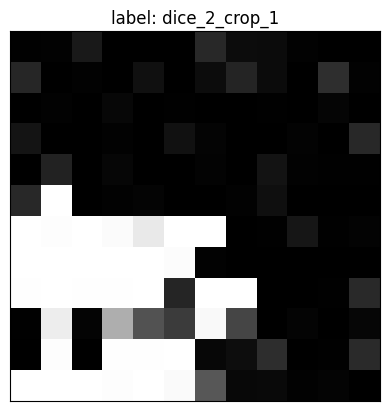

In [5]:
crop_path = "./runs/detect/exp61/crops/"

dice_crop_1_path = os.path.join(crop_path, "dice2/image_24921.jpg")
dice_crop_2_path = os.path.join(crop_path, "dice2/image_249212.jpg")

dice_crop_1 = cv2.imread(dice_crop_1_path)
dice_crop_2 = cv2.imread(dice_crop_2_path)

show_image(dice_crop_1, label="dice_2_crop_1")

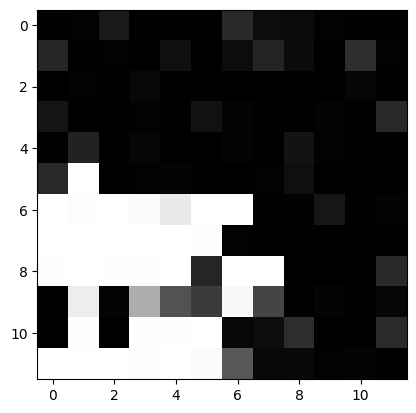

In [6]:
plt.imshow(dice_crop_1, label="dice_2_crop_2")

<h3>結論、考察</h3>
<span style="color: red">カスタムデータセット(自作データ)がテストデータを再現しきれておらず</span>、正しく物体を検知することができなかった。<br>
時間があれば、以下のことも検討してモデルの構築を行いたかった。
<ol>
    <li>ノイズを除去するレイヤーの追加</li>
    <li>自作データではなく、訓練データに対してノイズを追加</li>
    <li>正しくcropが行えたら、その画像をCNNにかけて分類</li>
</ol>